In [1]:
import pandas as pd
import sys
from pathlib import Path
import pastas as ps
import plotly.graph_objects as go

# Add the 'scripts' directory to sys.path
scripts_path = Path("../scripts").resolve()
if str(scripts_path) not in sys.path:
    sys.path.append(str(scripts_path))


### Loading Input Files

In [2]:
from knmi_pull import fetch_knmi_prec_evap
data = fetch_knmi_prec_evap("249", "2000-01-01", "2025-06-01")

In [3]:
prec = data[0]
evap = data[1]

In [15]:
# 1. Load Excel file
file_path_excel = Path("../input_files/input_single/13_7_HB21_PB1.xlsx")
df_head = pd.read_excel(file_path_excel)

print(df_head.head(50))

              DateTime  HB28_PB1
0  2023-11-10 00:00:00       NaN
1  2023-11-10 01:00:00       NaN
2  2023-11-10 02:00:00       NaN
3  2023-11-10 03:00:00       NaN
4  2023-11-10 04:00:00       NaN
5  2023-11-10 05:00:00       NaN
6  2023-11-10 06:00:00       NaN
7  2023-11-10 07:00:00       NaN
8  2023-11-10 08:00:00       NaN
9  2023-11-10 09:00:00       NaN
10 2023-11-10 10:00:00     2.172
11 2023-11-10 11:00:00     2.170
12 2023-11-10 12:00:00     2.178
13 2023-11-10 13:00:00     2.189
14 2023-11-10 14:00:00     2.305
15 2023-11-10 15:00:00     2.347
16 2023-11-10 16:00:00     2.347
17 2023-11-10 17:00:00     2.339
18 2023-11-10 18:00:00     2.331
19 2023-11-10 19:00:00     2.323
20 2023-11-10 20:00:00     2.321
21 2023-11-10 21:00:00     2.313
22 2023-11-10 22:00:00     2.305
23 2023-11-10 23:00:00     2.296
24 2023-11-11 00:00:00     2.286
25 2023-11-11 01:00:00     2.277
26 2023-11-11 02:00:00     2.267
27 2023-11-11 03:00:00     2.261
28 2023-11-11 04:00:00     2.255
29 2023-11

In [5]:
# 2. Convert 'time' column to datetime using flexible parsing
df_head['time'] = pd.to_datetime(df_head['DateTime'], format='mixed', dayfirst=True)

# 3. Set datetime column as index
df_head.set_index('time', inplace=True)

# 4. Resample to daily mean
head_daily_mean = df_head['HB28_PB1'].resample("D").mean().dropna()

#### Waterhoogte systeem

In [6]:
# 1. Load Excel file
file_path_waterhoogte = Path("../input_files/input_single/waterhoogte_drieban.xlsx")
df = pd.read_excel(file_path_waterhoogte)

# 2. Convert 'datetime' column to datetime type
df['datetime'] = pd.to_datetime(df['datetime'])

# 3. Set datetime as index
df.set_index('datetime', inplace=True)

# 4. Resample to daily mean (will have missing dates if no data on some days)
waterhoogte_daily_mean = df['waterhoogte'].resample("D").mean()

# 5. Fill missing days with a method or value, e.g., forward fill or zero (if appropriate)
waterhoogte_daily_mean = waterhoogte_daily_mean.ffill()  # or .bfill(), or .fillna(0)

# 6. Now frequency can be inferred correctly
waterhoogte_daily_mean.index.freq = "D"

### Gegevenscontrole

In [ ]:
import plotly.graph_objects as go

# Align all series to the index of head_daily_mean
common_index = head_daily_mean.dropna().index
prec_aligned = prec.reindex(common_index).fillna(0)
evap_aligned = evap.reindex(common_index).fillna(0)
waterhoogte_aligned = waterhoogte_daily_mean.reindex(common_index).fillna(method="ffill")

fig = go.Figure()

# Precipitation
fig.add_trace(go.Scatter(
    x=common_index, y=prec_aligned,
    mode='lines', name='Precipitation (mm/dag)',
    yaxis='y2', line=dict(color='blue')
))

# Evaporation
fig.add_trace(go.Scatter(
    x=common_index, y=evap_aligned,
    mode='lines', name='Evaporation (mm/dag)',
    yaxis='y2', line=dict(color='orange')
))

# Groundwater head
fig.add_trace(go.Scatter(
    x=common_index, y=head_daily_mean.reindex(common_index),
    mode='lines', name='Stijghoogte (m NAP)',
    yaxis='y1', line=dict(color='green')
))

# Surface water level
fig.add_trace(go.Scatter(
    x=common_index, y=waterhoogte_aligned,
    mode='lines', name='Waterhoogte Markermeer',
    yaxis='y1', line=dict(color='purple')
))

# Layout
fig.update_layout(
    title="Meteorologische en Hydrologische Tijdreeksen",
    xaxis=dict(title='Datum'),
    yaxis=dict(title='Grondwater- en Waterstand (m NAP)', side='left'),
    yaxis2=dict(title='Neerslag en Verdamping (mm/dag)', overlaying='y', side='right'),
    legend=dict(x=0.01, y=0.99),
    height=500,
    width=1500
)

fig.show()


Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

In [8]:
start_head_series = head_daily_mean.index.min()
end_head_series = head_daily_mean.index.max()

print(start_head_series, end_head_series)

2023-11-10 00:00:00 2025-02-25 00:00:00


### Model neerzetten

Fit report TarsoStyleModel        Fit Statistics
nfev    25                     EVP         75.90
nobs    474                    R2           0.76
noise   True                   RMSE         0.27
tmin    2023-11-10 00:00:00    AICc     -2199.36
tmax    2025-02-25 00:00:00    BIC      -2174.57
freq    D                      Obj          2.23
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (6 optimized)
                optimal    initial  vary
precip_A       0.351580   0.210716  True
precip_a      35.611216  10.000000  True
evap_A        -1.018324  -0.433329  True
evap_a       360.741653  10.000000  True
constant_d     2.736268   1.408101  True
noise_alpha   13.795567   1.000000  True

Warnings! (3)
Response tmax for 'evap' > than calibration period.
Response tmax for 'precip' > than warmup period.
Response tmax for 'evap' > than warmup period.


[<Axes: xlabel='time', ylabel='Head'>,
 <Axes: xlabel='time'>,
 <Axes: title={'right': "Stresses: ['Precipitation']"}, xlabel='DATE', ylabel='Rise'>,
 <Axes: title={'center': 'Step response'}, xlabel='Time [days]'>,
 <Axes: title={'right': "Stresses: ['ET']"}, xlabel='DATE', ylabel='Rise'>,
 <Axes: title={'center': 'Step response'}, xlabel='Time [days]'>,
 <Axes: title={'left': 'Model Parameters ($n_c$=6)'}>]

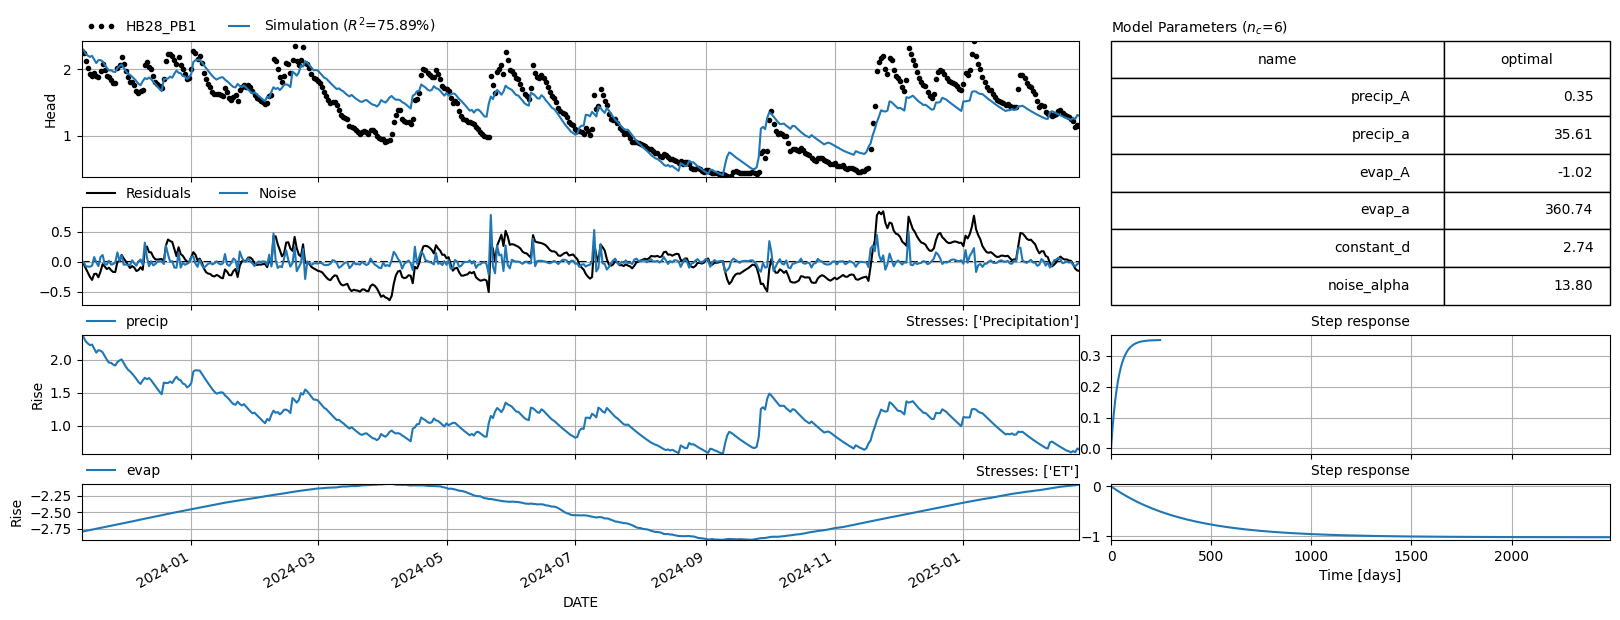

In [ ]:
# 1. Create the model
ml = ps.Model(head_daily_mean, name="TarsoStyleModel")

# 2. Add precipitation stressor
rain = ps.StressModel(prec, rfunc=ps.Exponential(), name="precip", settings="prec")
ml.add_stressmodel(rain)

# 3. Add evaporation stressor (with negative impact)
evap_sm = ps.StressModel(evap, rfunc=ps.Exponential(), name="evap", settings="evap", up=False)
ml.add_stressmodel(evap_sm)

# # 4. Optional: Add extra stressor (e.g. surface water)
# extra = ps.StressModel(waterhoogte_daily_mean, rfunc=ps.FourParam(), name="extra", settings="head", up=True)
# ml.add_stressmodel(extra)

# 5. Add a noise model (e.g. AR(1) or AR(2))
noise_model = ps.ArNoiseModel(1)  # AR(2)
ml.add_noisemodel(noise_model)

# 6. Solve the model
ml.solve(tmin=start_head_series, tmax=end_head_series, solver=ps.LeastSquares(), report=True)

# 7. Plot results
ml.plots.results(figsize=(16, 6))

[<Axes: xlabel='Simulated values', ylabel='Residuals'>,
 <Axes: xlabel='Simulated values', ylabel='$\\sqrt{|Residuals|}$'>,
 <Axes: title={'center': 'Noise (n=473, $\\mu$=0.00)'}, xlabel='time', ylabel='Noise'>,
 <Axes: title={'center': 'Histogram'}, ylabel='Probability density'>,
 <Axes: xlabel='Lag [Days]', ylabel='Autocorrelation [-]'>,
 <Axes: title={'center': 'Probability Plot'}, xlabel='Theoretical quantiles', ylabel='Ordered Values'>]

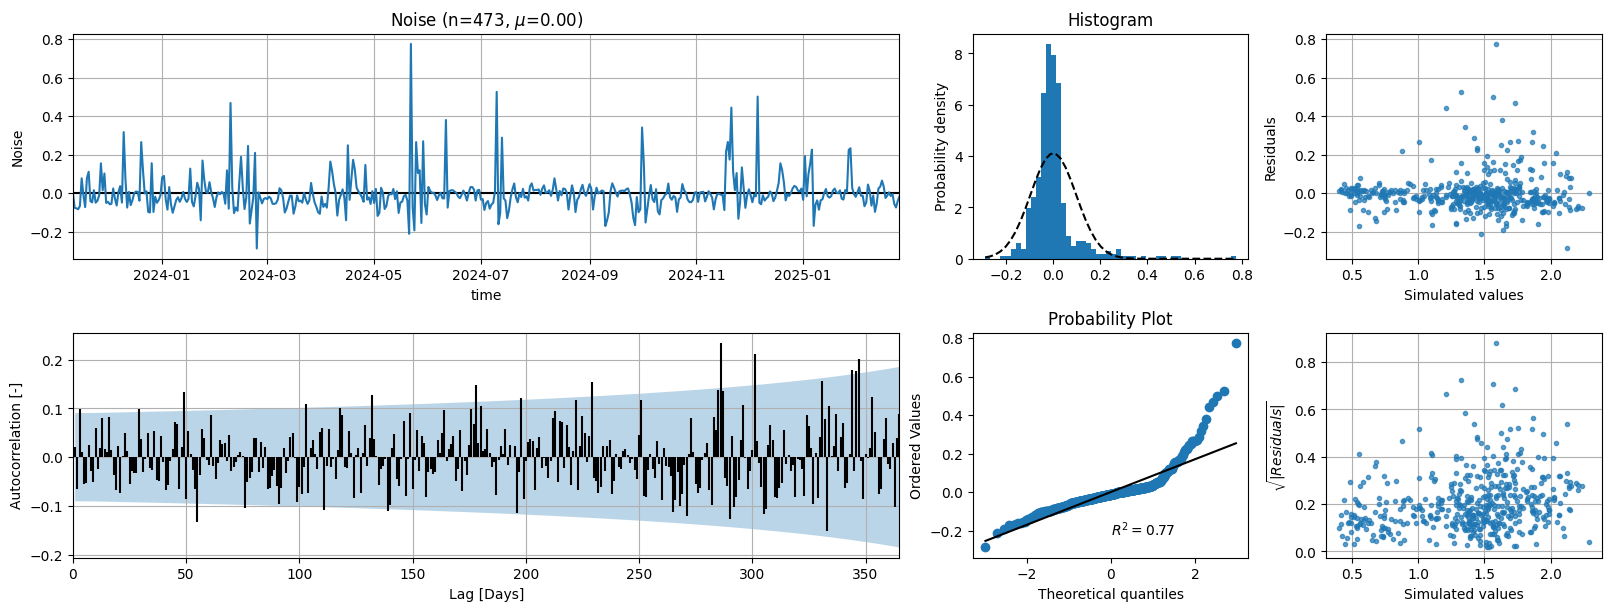

In [10]:
ml.plots.diagnostics(figsize=(16, 6))

array([<Axes: xlabel='time', ylabel='Head'>,
       <Axes: title={'center': 'precip'}, xlabel='DATE', ylabel='Rise'>,
       <Axes: title={'center': 'evap'}, xlabel='DATE', ylabel='Rise'>],
      dtype=object)

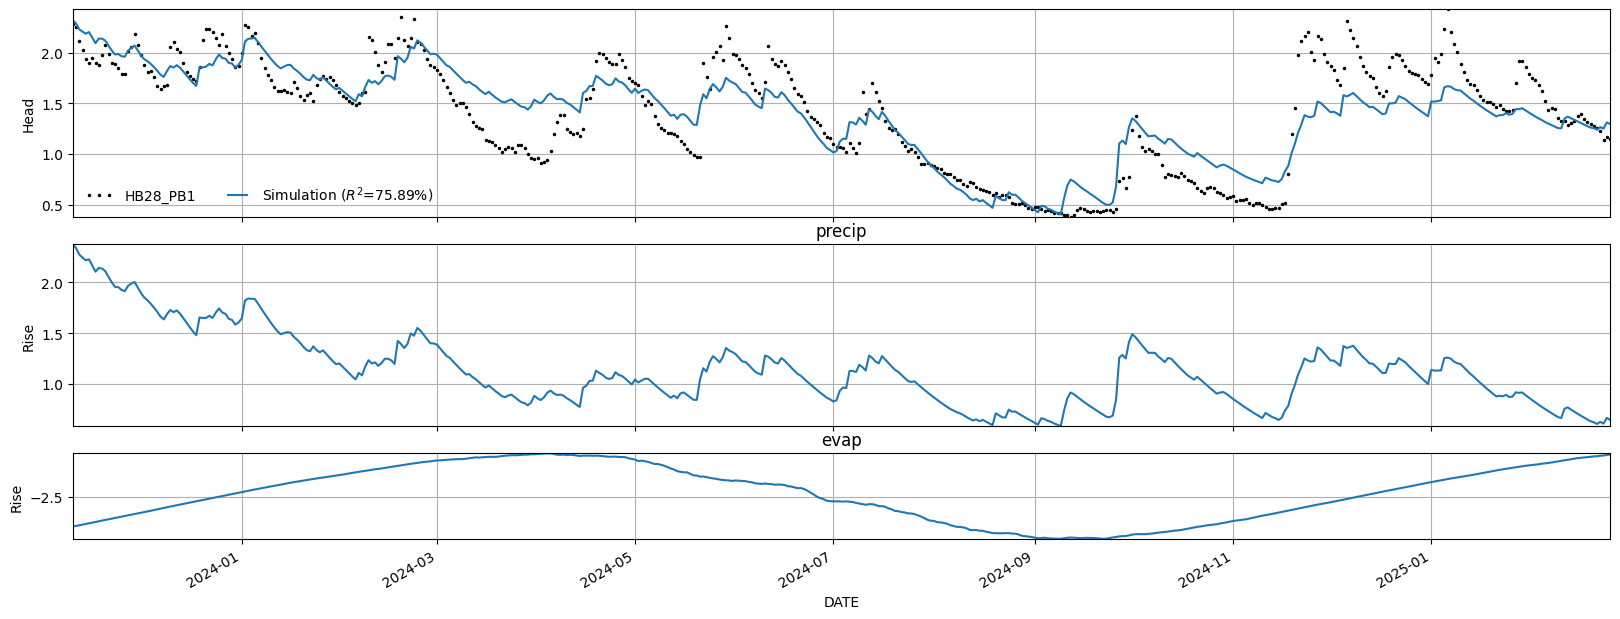

In [11]:
ml.plots.decomposition(figsize=(16, 6))

In [12]:
print(ml.stats.diagnostics(alpha=0.05))

                  Checks Statistic P-value  Reject H0 ($\alpha$=0.05)
Shapiroo       Normality      0.77    0.00                       True
D'Agostino     Normality    320.90    0.00                       True
Runs test      Autocorr.     -4.69    0.00                       True
Ljung-Box      Autocorr.     17.09    0.25                      False
Durbin-Watson  Autocorr.      1.96     nan                      False


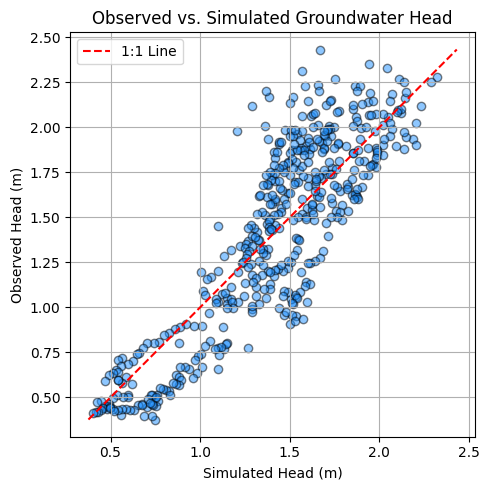

In [13]:
import matplotlib.pyplot as plt

# Get observed and simulated values
observed = ml.observations()  # <- no .series here!
simulated = ml.simulate()

# Create scatter plot
plt.figure(figsize=(5, 5))
plt.scatter(simulated, observed, alpha=0.5, color='dodgerblue', edgecolor='k')

# Add 45-degree reference line
min_val = min(observed.min(), simulated.min())
max_val = max(observed.max(), simulated.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="1:1 Line")

# Labels and title
plt.xlabel("Simulated Head (m)")
plt.ylabel("Observed Head (m)")
plt.title("Observed vs. Simulated Groundwater Head")
plt.grid(True)
plt.legend()
plt.axis("equal")
plt.tight_layout()
plt.show()


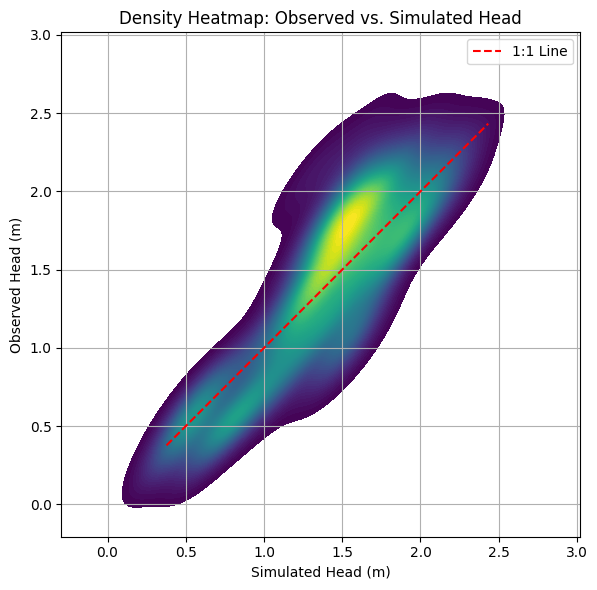

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get observed and simulated values
observed = ml.observations()
simulated = ml.simulate()

# Create density plot
plt.figure(figsize=(6, 6))
sns.kdeplot(
    x=simulated, y=observed,
    cmap="viridis", fill=True, thresh=0.01, levels=100
)

# Add 45-degree reference line
min_val = min(observed.min(), simulated.min())
max_val = max(observed.max(), simulated.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="1:1 Line")

# Labels and title
plt.xlabel("Simulated Head (m)")
plt.ylabel("Observed Head (m)")
plt.title("Density Heatmap: Observed vs. Simulated Head")
plt.grid(True)
plt.legend()
plt.axis("equal")
plt.tight_layout()
plt.show()
